In [1]:
# !pip install --upgrade-strategy=only-if-needed tensorflow~=1.6.0rc0
# !pip install -U gensim~=3.2.0

In [3]:
import gensim
import gzip
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from gensim.test.utils import common_texts, get_tmpfile
from model_tool import ToxModel
execfile("./FairAI.py")

# Load word2vec embedding model

In [4]:
local_dir_name = '../data'
WORD2VEC_FILE = os.path.join(local_dir_name+"/embeddings", "GoogleNews-vectors-negative300.bin.gz")
ANALOGIES_FILE = os.path.join(local_dir_name, "questions-words.txt")
if not 'client' in vars():
  print "Loading word embeddings from %s" % WORD2VEC_FILE
  with gzip.GzipFile(fileobj=open(WORD2VEC_FILE, 'r')) as f:
    client = load_word2vec_format(f, max_num_words=2000000)
embeddings = client

Loading word embeddings from ../data/embeddings/GoogleNews-vectors-negative300.bin.gz
vector_size =  300
Loading 2000000 embeddings
('duplicate words detected, shrinking matrix size from %i to %i', 3000000, 2000000)
('loaded %s matrix', (2000000, 300))


# Load GloVe embedding model

In [81]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '../data/glove.6B/glove.6B.100d.txt'
word2vec_output_file = '../data/glove.6B/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)
client = embeddings

## Are there harmful anaolgies with repsect to negative sentiment?

In [5]:
A = "asian"
B = "american"
C = "smart"
NUM_ANALOGIES = 5

in_arr = []
for i, word in enumerate((A, B, C)):
  in_arr.append(client.word_vec(word))
in_arr = np.array([in_arr])

print_knn(client, -in_arr[0, 0, :] + in_arr[0, 1, :] + in_arr[0, 2, :],
          NUM_ANALOGIES)

5 closest neighbors to A-B+C:
smart : score=0.668151
intelligent : score=0.454270
dumb : score=0.442581
smarter : score=0.412079
american : score=0.410000


In [6]:
analogies = load_analogies(ANALOGIES_FILE)
print "\n".join("%s is to %s as %s is to %s" % tuple(x) for x in analogies[-20:])

loaded 19544 analogies
write is to writes as increase is to increases
write is to writes as listen is to listens
write is to writes as play is to plays
write is to writes as predict is to predicts
write is to writes as provide is to provides
write is to writes as say is to says
write is to writes as scream is to screams
write is to writes as search is to searches
write is to writes as see is to sees
write is to writes as shuffle is to shuffles
write is to writes as sing is to sings
write is to writes as sit is to sits
write is to writes as slow is to slows
write is to writes as speak is to speaks
write is to writes as swim is to swims
write is to writes as talk is to talks
write is to writes as think is to thinks
write is to writes as vanish is to vanishes
write is to writes as walk is to walks
write is to writes as work is to works


# Create directional sentiment word vector

In [100]:
pos_words = load_lexicon("../data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("../data/opinion_lexicon/negative-words.txt")
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([0 for entry in pos_vectors] + [1 for entry in neg_vectors])
train_vectors, test_vectors, train_targets, test_targets = train_test_split(vectors, targets, test_size=0.1, random_state=0)

words_in_embeddings = []
for i,j in enumerate(pos_words+neg_words):
    if j.lower() in embeddings:
        words_in_embeddings.append(j)

In [101]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors,train_targets)
clf.score(test_vectors,test_targets)

0.8990384615384616

# Create sentiment subspaces via Bolukbasi et al. 2016

<BarContainer object of 100 artists>

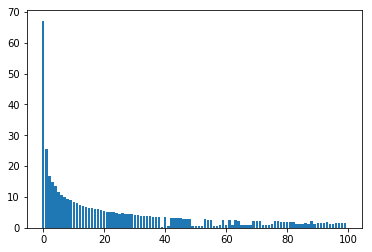

In [114]:
%matplotlib inline

import nltk 
from nltk.corpus import wordnet 
good = []
bad=  []

for word in pos_words:
    a = wordnet.synsets(word)
    if len(a)>0:
        syn = a[0] .lemmas()[0]
        if len(syn.antonyms())>0:
            good.append(word)
            bad.append(syn.antonyms()[0].name()) 
            
good_vectors=[]
bad_vectors = []
# good = ['good','beautiful','happy','positive','compentent','smart','interesting','pleasant','best','honest','wealthy','wonderful']
# bad = ['bad','ugly','sad','negative','incompetent','dumb','boring','horrible','worst','corrupt','poor','awful']
# good = ['amazing']
# bad = ['horrible']
choices = np.random.choice(len(good),20)
for i,j in zip(good,bad):
    if i in embeddings and j in embeddings:
        good_vectors.append(_np_normalize(embeddings[i]))
        bad_vectors.append(_np_normalize(embeddings[j]))

good_vectors = np.array(good_vectors)
bad_vectors = np.array(bad_vectors)
X = good_vectors-bad_vectors
m = np.dot(X.T,X)
evals, evecs = np.linalg.eig(m)
vec = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.bar(np.arange(100),evals[:100])

## create sentiment subspace via our method

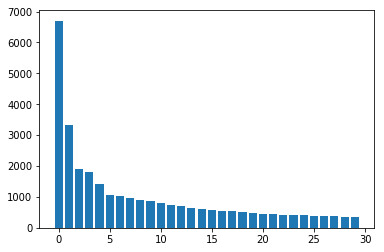

In [117]:
pos_vectors1=pos_vectors[np.random.choice(len(pos_vectors),len(pos_vectors))]
m=np.dot(pos_vectors1.T,pos_vectors1)
evals, evecs = np.linalg.eig(m)
vec_pos = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
fig = plt.figure()
plt.bar(np.arange(30),evals[:30])
fig.savefig('/home/csweeney/Downloads/glove_pos_s.png', format='png',dpi=300,bbox_inches='tight')

In [118]:
neg_vectors1=neg_vectors[np.random.choice(len(pos_vectors1),len(pos_vectors1))]

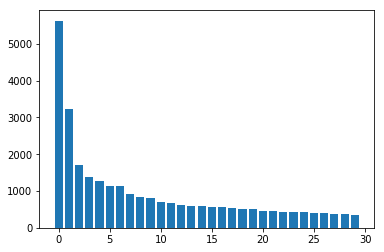

In [119]:
m=np.dot(neg_vectors1.T,neg_vectors1)
evals, evecs = np.linalg.eig(m)
vec_neg = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.figure()
plt.bar(np.arange(30),evals[:30])
fig.savefig('/home/csweeney/Downloads/glove_neg_s.png', format='png',dpi=300,bbox_inches='tight')

In [120]:
##get direcitonal sentiment vector
# vec=vec_pos-vec_neg
vec=(vec_pos-vec_neg)

## Or load in the vector from the paper

In [7]:
#optionally read weights
import pickle
vec= np.array([])
with open('./best_toxic_vector.pkl', "rb") as openfile:
    while True:
        try:
            vec = pickle.load(openfile)
        except EOFError:
            break

## how does the sign of projection correlate with positive/negative labels

In [121]:
#sanity check
WORD = "horrible"
word_vec = _np_normalize(client.word_vec(WORD))
print vec.dot(word_vec.T)

-0.19016138


In [122]:
count = 0 
for i,j in zip(vectors,(targets*2-1)*-1):
    if int(np.sign(i.dot(vec))) == j:
        count+=1
print count/float(len(targets))

0.851691518358


In [58]:
MODEL_DIR = '../models/'
debias_model_name = 'wiki_debias_cnn_v3_{}'.format(109)
debias_model = ToxModel(debias_model_name,model_dir=MODEL_DIR)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 4
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
model_name: wiki_debias_cnn_v3_109
max_sequence_length: 250
stop_early: True
embedding_trainable: False



In [59]:
count = 0 
threshold = .5
for  index, (i,j) in enumerate(zip(vectors,(targets*2-1)*-1)):
    if (int(np.sign(i.dot(vec)))+1)/2 == (debias_model.predict([words_in_embeddings[index]])>=threshold):
        count+=1
print count/float(len(targets))

0.966502619463


In [407]:
#save weights
import pickle
with open('glove_vec_new_s.pkl', 'wb') as f:
    pickle.dump(vec, f)

## define set of identity terms

In [8]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']
identities = filter(lambda x: x in embeddings,identities)
nationalities=[
'German',
'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]
nationalities = filter(lambda x: x.lower() in embeddings,nationalities)

religions =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
#     'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
#     'Diasporic',
    'Sikh',
#     'Juche',
    'Jewish',
#     'Bahai',
#     'Jains',
#     'Shinto',
#     'Pagan'
]
names = ["Ebony","Alonzo","Amanda","Adam","Jasmine","Alphonse","Betsy","Alan","Lakisha","Darnell","Courtney","Andrew","Latisha","Jamel","Ellen","Frank","Latoya","Jerome","Heather","Harry","Nichelle","Lamar","Katie","Jack","Shaniqua","Leroy","Kristin","Josh","Shereen","Malik","Melanie","Justin","Tanisha","Terrence","Nancy","Roger","Tia","Torrance","Stephanie","Ryan"]
names = filter(lambda x: x.lower() in embeddings,names)

gender = ["she","her","he","him", "woman","man"," girl","boy","sister","brother","daughter","son","wife","husband","girlfriend","boyfriend","mother","father", "aunt","uncle","mommy","dad"]

In [8]:
words = filter(lambda x: x.lower() in embeddings,religions)
df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: _np_normalize(embeddings[w.lower()]).dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df

         word  sentiment_score
0     Zionist        -0.117124
5     Atheist        -0.113430
8        Sikh        -0.046505
6       Hindu        -0.010465
4  Protestant         0.009221
3     Islamic         0.075022
9      Jewish         0.091240
1    Catholic         0.104941
7    Buddhist         0.133636
2   Christian         0.195865


In [123]:
tf.reset_default_graph()
labels  = embeddings.syn0norm
protect=[]
for i in labels:
    protect.append(_np_normalize(i).dot(vec))
protect = np.expand_dims(np.array(protect),1)
print(" training on %s word vectors" % (np.shape(protect)[0]))

 training on 400000 word vectors


In [124]:
#bookeeping
w_h=[]
# weights = [.5,1,2,4,8,16]
weights = [.5]
pairs = []
unbiased=[]

In [125]:
%%time
pred_learning_rate = 2**-16
protect_learning_rate = 2**-16
num_steps = 30000
batch_size = 1000

embed_dim = 100
projection_dims = 1


sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
with tf.variable_scope('var_scope', reuse=tf.AUTO_REUSE):
    for i in weights:
        print "weights", i
        protect_loss_weight = i

        labels_p = tf.placeholder(tf.float32, shape=[None, embed_dim], name="labels")
        protect_p = tf.placeholder(tf.float32, shape=[None, 1], name="protect")

        # projection is the space onto which we are "projecting". By default, this is
        # one-dimensional, but this can be tuned by projection_dims
        projection = tf.get_variable("projection", [embed_dim, projection_dims])

        # build the prediction layer
        pred = labels_p
        pred -= tf.matmul(tf.matmul(pred, projection), tf.transpose(projection))

        trained_model = AdversarialEmbeddingModel(
            client, embed_dim, projection, projection_dims, pred,verbose=True)
        trained_model.fit(sess, labels, labels_p, protect, protect_p, vec,
                  pred_learning_rate,
                protect_learning_rate, protect_loss_weight, num_steps, batch_size)
        w=None
        with sess.as_default(): w= trained_model.projection.eval()
        w_h.append(w)

weights 0.5
step: 0; pred_loss_o: 0.000372; protect_loss_o: 0.028099
proj_o: 1.444686; dot(proj_o, adv_direction): 0.111521)
step: 1000; pred_loss_o: 0.000479; protect_loss_o: 0.024149
proj_o: 1.462235; dot(proj_o, adv_direction): 0.156397)
step: 2000; pred_loss_o: 0.000659; protect_loss_o: 0.022457
proj_o: 1.493216; dot(proj_o, adv_direction): 0.207968)
step: 3000; pred_loss_o: 0.000916; protect_loss_o: 0.021698
proj_o: 1.535168; dot(proj_o, adv_direction): 0.261263)
step: 4000; pred_loss_o: 0.001246; protect_loss_o: 0.021081
proj_o: 1.583560; dot(proj_o, adv_direction): 0.312167)
step: 5000; pred_loss_o: 0.001618; protect_loss_o: 0.020183
proj_o: 1.630969; dot(proj_o, adv_direction): 0.359335)
step: 6000; pred_loss_o: 0.001962; protect_loss_o: 0.018887
proj_o: 1.669477; dot(proj_o, adv_direction): 0.401329)
step: 7000; pred_loss_o: 0.002189; protect_loss_o: 0.017277
proj_o: 1.691283; dot(proj_o, adv_direction): 0.437148)
step: 8000; pred_loss_o: 0.002295; protect_loss_o: 0.015544
pro

In [74]:
#optionally read weights
import pickle
vec= np.array([])
with open('./glove_vec.pkl', "rb") as openfile:
    while True:
        try:
            vec = pickle.load(openfile)
        except EOFError:
            break

In [75]:
#optionally read weights
import pickle
p = None
with (open('./', "rb")) as openfile:
    while True:
        try:
            p=pickle.load(openfile)
        except EOFError:
            break
w_h = p

In [22]:
unbiased = []
pairs = []

In [23]:
for j in [names]: 
    words = j
    a=map(lambda a: _np_normalize(embeddings[a.lower()]).dot(vec),words)
    s1 = np.sum(np.abs(np.array(a)))
    print(s1)
    unbiased.append(s1)
    s2= evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :x)
    print(s2)
    pairs.append(s2)
    for w in w_h:
            a=map(lambda a: (_np_normalize(embeddings[a.lower()])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings[a.lower()])))).dot(vec),words)
            s = np.sum(np.abs(np.array(a)))
            print(s)
            unbiased.append(s)
            
            s2= evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :(x-(np.dot(np.dot(w,w.T),x))))
            print(s2)
            pairs.append(s2)

11.4242935
((0.6238773451304681, 1.7963247628700625e-39), SpearmanrResult(correlation=0.6589215888009288, pvalue=2.5346056459149263e-45), 0.0)
2.7408187
((0.6224447658866008, 3.00504083024793e-39), SpearmanrResult(correlation=0.65184927232812, pvalue=4.437628061417715e-44), 0.0)
3.8566406
((0.623062490972614, 2.4078786460808566e-39), SpearmanrResult(correlation=0.6546950043136879, pvalue=1.4155220846120511e-44), 0.0)
3.7560465
((0.623960908887512, 1.7430669996765395e-39), SpearmanrResult(correlation=0.6543636706451544, pvalue=1.6179680577963702e-44), 0.0)
3.388647
((0.6214944487717432, 4.221348343255321e-39), SpearmanrResult(correlation=0.6512557635624597, pvalue=5.623076240070313e-44), 0.0)
3.6901522
((0.6218769851358951, 3.6821168467631286e-39), SpearmanrResult(correlation=0.6504858799785969, pvalue=7.638539838545728e-44), 0.0)
4.164101
((0.6224870125543401, 2.959899436796696e-39), SpearmanrResult(correlation=0.6527206430463546, pvalue=3.1316310216308743e-44), 0.0)


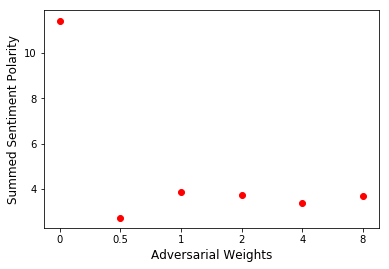

In [26]:
%matplotlib inline
fig = plt.figure()
plt.scatter(np.arange(len(weights)),unbiased[:-1],color="red")
plt.xticks(np.arange(len(weights)),[0]+weights[:-1])
plt.xlabel("Adversarial Weights",fontsize=12)
plt.ylabel("Summed Sentiment Polarity",fontsize=12)
fig.savefig('/home/csweeney/Downloads/nglove_bb1.png', format='png',dpi=300,bbox_inches='tight')
# plt.ylim(,.8)

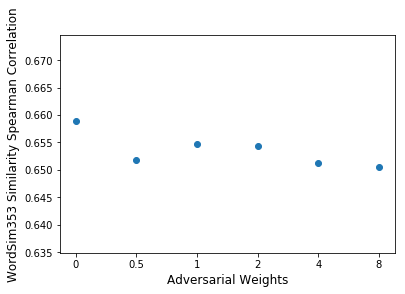

In [29]:
# pairs= map(lambda x:x[1][0], pairs)
fig = plt.figure()
plt.scatter(x=np.arange(len(weights)),y=pairs[:-1])
plt.xticks(np.arange(len(weights)),[0]+weights[:-1])
plt.xlabel("Adversarial Weights",fontsize=12)
plt.ylabel("WordSim353 Similarity Spearman Correlation",fontsize=12)
fig.savefig('/home/csweeney/Downloads/noglove_bb1.png', format='png',dpi=300,bbox_inches='tight')
# plt.ylim(,.8)

In [108]:
# #save weights
# import pickle
# with open('new_w2v_s.pkl', 'wb') as f:
#     pickle.dump(w_h, f)

## Rembed seleceted word and save model

In [30]:
glove_input_file = '../data/glove.6B/glove.6B.100d.txt'
word2vec_output_file = '../data/glove.6B/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings_debias = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

In [31]:
w = w_h[0]
for i in identities+names+nationalities+religions:
    if i.lower() in embeddings_debias:
        embeddings_debias.wv.syn0[embeddings_debias.wv.vocab[i.lower()].index] = _np_normalize(embeddings_debias[i.lower()])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings_debias[i.lower()])))
embeddings_debias.wv.syn0norm = None
embeddings_debias.wv.init_sims()
embeddings_debias.save_word2vec_format("glove_debias_new_sentiment_with_sentiment_vec.txt", binary=False)

In [25]:
# embeddings = gensim.models.KeyedVectors.load_word2vec_format('detoxified_word2vec_embeddings.txt',binary=False,limit=13000)
#embeddings.save_word2vec_format("detoxified_word2vec_embeddings_light.txt", binary=False)

## Evaluate Word Embeddings before and after debiasing

In [126]:
w = w_h[0]

In [127]:
client.similar_by_vector(_np_normalize(embeddings['male']))

[(u'male', 0.9999999403953552),
 (u'female', 0.9464976191520691),
 (u'adult', 0.7003792524337769),
 (u'women', 0.6834636330604553),
 (u'males', 0.6686494946479797),
 (u'woman', 0.6552181243896484),
 (u'young', 0.6431192755699158),
 (u'females', 0.6378622651100159),
 (u'sex', 0.6297175884246826),
 (u'child', 0.628372311592102)]

In [129]:
client.similar_by_vector(_np_normalize(embeddings['male'])-np.dot(np.dot(w,w.T),_np_normalize(embeddings['male'])))

[(u'male', 0.974506676197052),
 (u'female', 0.9130117893218994),
 (u'adult', 0.6568492650985718),
 (u'males', 0.6567750573158264),
 (u'sex', 0.6331608295440674),
 (u'women', 0.6308697462081909),
 (u'females', 0.6281332969665527),
 (u'woman', 0.6130436062812805),
 (u'offspring', 0.6121788024902344),
 (u'sexual', 0.6034080982208252)]

In [137]:
words= filter(lambda x: x.lower() in embeddings,names)

summed toxity polarity:  2.2352436


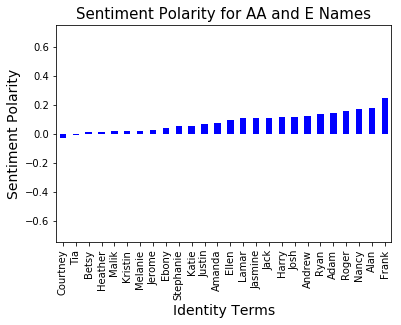

In [138]:
%matplotlib inline

df1 = pd.DataFrame(data={"Identity Terms": list(words)})
df1["sentiment polarity"] = df1["Identity Terms"].map(
        lambda a: (_np_normalize(embeddings[a.lower()]).dot(vec)))
df1.sort_values(by="sentiment polarity", inplace=True)
# fig = plt.figure() 
# fig.set_size_inches(18.5, 10.5)
fig = df1.plot.bar(legend = False, ylim= (-.75,.75),x="Identity Terms",y="sentiment polarity",fontsize=10, color = 'blue',colormap='Paired')
plt.xlabel('Identity Terms', fontsize=14)
plt.ylabel('Sentiment Polarity', fontsize=14)
plt.title("Sentiment Polarity for AA and E Names",fontsize= 15)
a=map(lambda a: (_np_normalize(embeddings[a.lower()])).dot(vec),words)
print "summed toxity polarity: ", np.sum(np.abs(np.array(a)))
plt.draw()
fig.get_figure().savefig('/home/csweeney/Downloads/1n.png', format='png',dpi=300,bbox_inches='tight')


In [139]:
words= df1["Identity Terms"].values

summed toxity polarity:  1.0473378


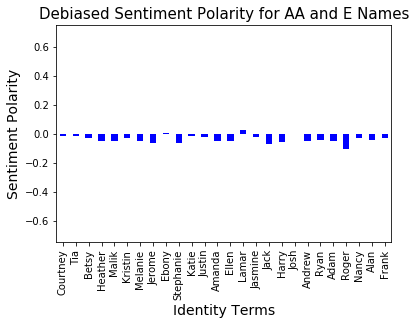

In [140]:
%matplotlib inline
df = pd.DataFrame(data={"Identity Terms": list(words)})
df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (_np_normalize(embeddings[a.lower()])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings[a.lower()])))).dot(vec))
#     df.sort_values(by="sentiment polarity", inplace=True)
# plt.figure()
fig = df.plot.bar(legend = False, ylim= (-.75,.75),x="Identity Terms",y="sentiment polarity",fontsize=10,color='blue', colormap='Paired')
plt.xlabel('Identity Terms', fontsize=14)
plt.ylabel('Sentiment Polarity', fontsize=14)
plt.title("Debiased Sentiment Polarity for AA and E Names",fontsize= 15)
a=map(lambda a: (_np_normalize(embeddings[a.lower()])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings[a.lower()])))).dot(vec),words)
print "summed toxity polarity: ", np.sum(np.abs(np.array(a)))
plt.draw()
fig.get_figure().savefig('/home/csweeney/Downloads/2n.png', format='png',dpi=300,bbox_inches='tight')


(-0.6, 0.6)

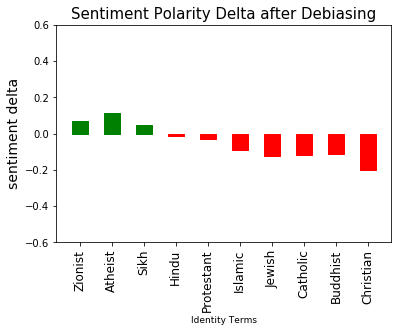

In [134]:
plt.figure()
plt.xlabel('Identity Terms', fontsize=9)
plt.ylabel('sentiment delta', fontsize=14)
plt.title("Sentiment Polarity Delta after Debiasing",fontsize= 15)
index = np.arange(len(words))
delta = df["sentiment polarity"].values-df1["sentiment polarity"].values
bar = plt.bar(index,delta,width=.5)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, words, fontsize=12, rotation=90)
plt.ylim(top=.6,bottom=-.6)

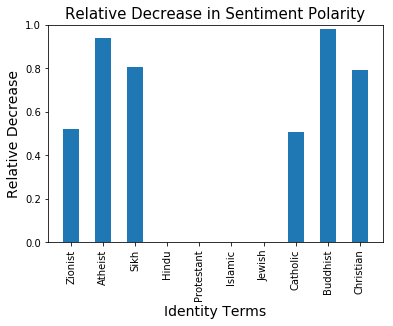

In [135]:
fig = plt.figure()
plt.xlabel('Identity Terms', fontsize=14)
plt.ylabel('Relative Decrease', fontsize=14)
plt.title("Relative Decrease in Sentiment Polarity",fontsize= 15)
index = np.arange(len(words))
delta = np.abs(df1["sentiment polarity"].values)-np.abs(df["sentiment polarity"].values)
plt.bar(index,delta/np.abs(df1["sentiment polarity"].values),width=.5)
# plt.bar(index,df["sentiment polarity"].values,width=.5)
# for i,j in enumerate(delta):
#     bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, words, fontsize=10, rotation=90)
plt.ylim(top=1,bottom=0)
fig.savefig('/home/csweeney/Downloads/gender_rebiased.png', format='png',dpi=300,bbox_inches='tight')


In [136]:
np.sum(delta/np.abs(df1["sentiment polarity"].values))/len(delta)

-0.29989783903572165

## test analogy accruacy on debiased word embeddings

In [70]:
(X,y,l) = load_vectors_test(embeddings,analogies)
analogy_accuracy(X,l,embeddings,n = 1,samples=100,model=lambda x :(x-(np.dot(np.dot(w,w.T),x))))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


0.21